In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation

In [11]:
def plot_signal(signal, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 2)
    plt.plot(signal)
    plt.title(title)

def plot_signals(signals, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 3)
    plt.imshow(signals, cmap='jet', aspect='auto')
    plt.title(title)

In [3]:
raw_data = open('sar_data/iw_sample/iw_sample.dat', 'rb')

In [4]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(raw_data)
    swath_packets = []
    while (raw_data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append(packet)
        except ValueError as ve:
            break
    return swath_packets      

In [5]:
swath_packets = get_packets_in_swath(raw_data, 10)

In [6]:
def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append(packet)
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

In [7]:
burst = get_packets_in_burst(swath_packets, 5)

In [8]:
def decode_signals(packets):
    signals = []
    index = 0
    for packet in packets:
        if index % 100 == 0:
            print(f"{index} of {len(packets)}")
        signals.append(packet.get_complex_samples()[0])
        index += 1
    return np.asarray(signals)

In [9]:
do_decode = False
save_decode = False
load_signals = False

if do_decode:
    signals = decode_signals(burst)
    if save_decode:
        np.save("burst_iw1_5.npy", signals)
if load_signals:
    signals = np.load("burst_iw1_5.npy")

0 of 1409
100 of 1409
200 of 1409
300 of 1409
400 of 1409
500 of 1409
600 of 1409
700 of 1409
800 of 1409
900 of 1409
1000 of 1409
1100 of 1409
1200 of 1409
1300 of 1409
1400 of 1409


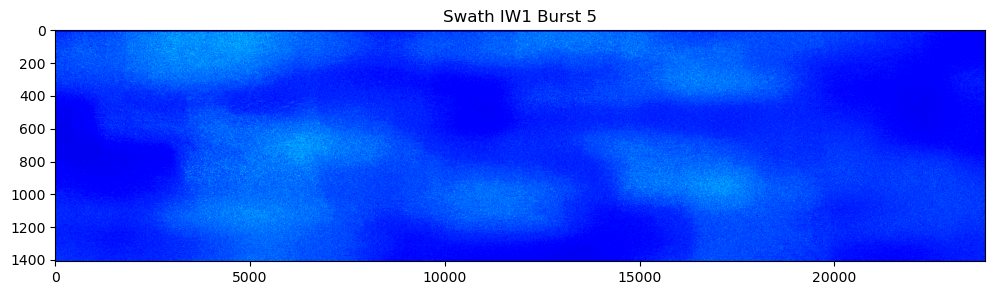

In [12]:
plot_signals(np.abs(signals) / np.max(np.abs(signals)), title="Swath IW1 Burst 5")

In [13]:
range_decimation_list = [
    112.6041667,
    100.0925926,
    0.000000000,
    83.41049387,
    66.72839509,
    56.30208336,
    50.04629632,
    25.02314816,
    64.34523813,
    46.91840280,
    17.32371796,
    54.59595962
]

def get_replica_chirps(packets):
    replica_chirps = []
    for packet in packets:
        secondary_header = packet.get_secondary_header()
        range_decimation = secondary_header['range_decimation']
        txpsf = secondary_header['tx_pulse_start_frequency']
        txprr = secondary_header['tx_ramp_rate']
        txpl  = secondary_header['pulse_length']
        phi_1 = txpsf - (txprr * (-txpl / 2))
        phi_2 = txprr / 2
        fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
        t = np.linspace(-0.5 * txpl, (0.5 * txpl), fs)
        chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
        replica_chirps.append(chirp)
    return np.asarray(replica_chirps)

In [14]:
replica_chirps = get_replica_chirps(burst)

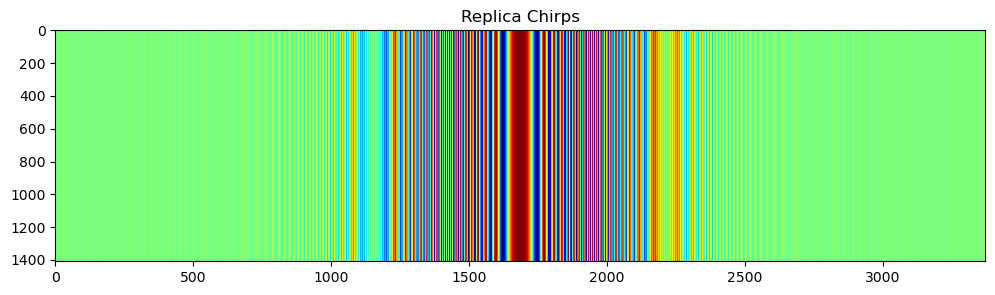

In [15]:
plot_signals(replica_chirps.real, title="Replica Chirps")

In [16]:
def get_reference_function(replica):
    num_samples = replica.shape[0]
    window = np.hanning(num_samples)
    reference = np.conj(replica) * window
    norm = np.abs(reference)
    energy = 0.0
    for i in range(num_samples):
        energy += (norm[i] * norm[i])
    energy /= num_samples
    for i in range(num_samples):
        reference[i] = reference[i] / energy
    return np.asarray(reference)

def pulse_compression(chirp, replica):
    pulse_compressed = []
    f_chirp = fft(chirp)
    ref_func = get_reference_function(replica)
    num_samples = f_chirp.shape[0]
    ref_func_samples = ref_func.shape[0]
    ref_func_padded = []
    for i in range(num_samples):
        if i < ref_func_samples:
            ref_func_padded.append(ref_func[i])
        else:
            ref_func_padded.append(0.0)
    f_ref_func = fft(ref_func_padded)
    for i in range(num_samples):
        pulse_compressed.append(f_chirp[i] * f_ref_func[i])
    return ifft(np.asarray(pulse_compressed))

In [17]:
pulse_compressed_signal = pulse_compression(signals[0], replica_chirps[0])

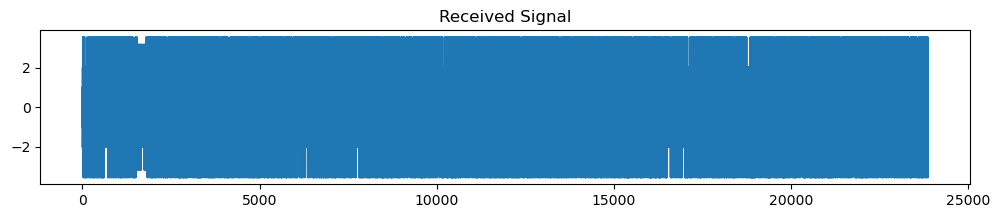

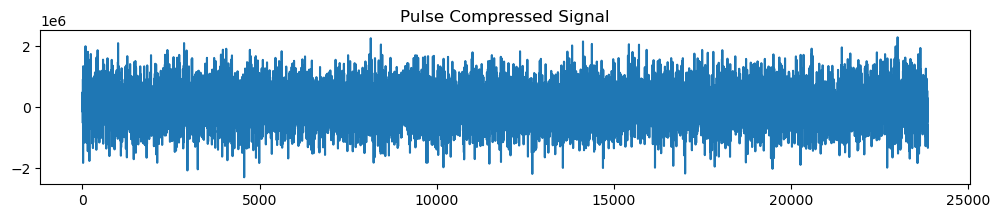

In [18]:
plot_signal(signals[0].real, title="Received Signal")
plot_signal(pulse_compressed_signal.real, title="Pulse Compressed Signal")

In [19]:
def range_compress_burst(signals, replica_chirps):
    num_packets = signals.shape[0]
    range_compressed_signals = np.zeros_like(signals)
    for i in range(num_packets):
        range_compressed_signals[i] = pulse_compression(signals[i], replica_chirps[i])
    return range_compressed_signals

In [20]:
range_compressed_burst = range_compress_burst(signals, replica_chirps)

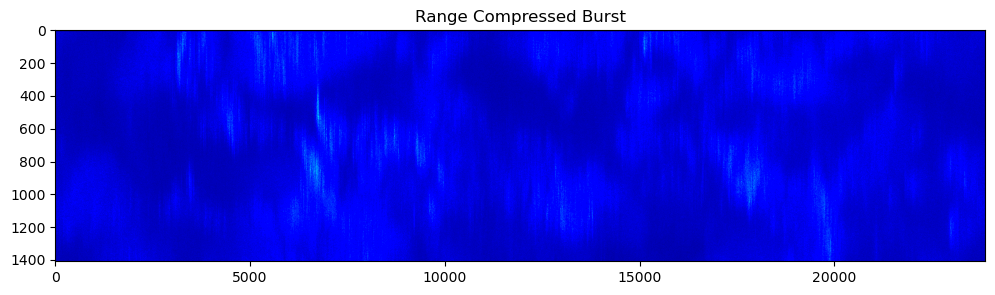

In [21]:
plot_signals(np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst)), title="Range Compressed Burst")

In [22]:
range_doppler_burst = fft(range_compressed_burst, axis=0)

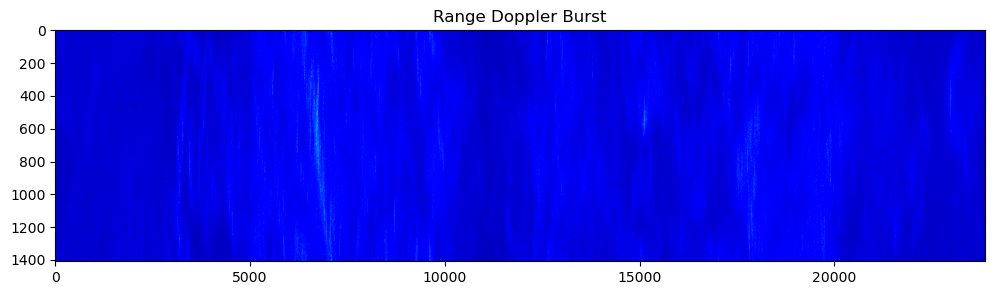

In [23]:
plot_signals(np.abs(range_doppler_burst) / np.max(np.abs(range_doppler_burst)), title="Range Doppler Burst")

In [24]:
def average_cross_correlation_coefficient(range_doppler_data):
    rows, cols = range_doppler_data.shape
    out_row = np.zeros_like(range_doppler_data[0])
    for i in range(rows - 1):
        out_row += range_doppler_data[i] * np.conj(range_doppler_data[i+1])
    return out_row

In [26]:
accc = average_cross_correlation_coefficient(range_doppler_burst)

In [29]:
avg_accc = np.sum(accc) / accc.shape[0]

In [33]:
angle = np.tan(avg_accc.imag / avg_accc.real)

In [41]:
prf = 1 / (burst[0].get_secondary_header()['pri'] * 0.000001)

In [43]:
fine_dc = -(prf/(2*pi))*angle

In [45]:
fine_dc

np.float64(-220.92988725217867)

In [66]:
from structs import SUB_COMM_KEY_POS, SUB_COMM_KEY_VAL, WORD_SIZE

def build_data_word_dict(packets):
    data_word_dicts = []
    sub_comm_dict = SUB_COMM_KEY_VAL.copy()
    
    initial_data_word_index = 0
    sc_data_word_index = 0

    for i in range(len(packets)):
        packet = packets[i]
        
        secondary_header = packet.get_secondary_header()

        sc_data_word_index = secondary_header['sc_data_word_index']
        if i == 0:
            initial_data_word_index = sc_data_word_index
        else:
            if sc_data_word_index == initial_data_word_index:
                data_word_dicts.append(sub_comm_dict)
                sub_comm_dict = SUB_COMM_KEY_VAL.copy()

        key, pos = SUB_COMM_KEY_POS[sc_data_word_index]
        pos = pos * WORD_SIZE
        data_word =  secondary_header['sc_data_word']
        sub_comm_dict[key] = sub_comm_dict[key][0:pos] + data_word + sub_comm_dict[key][pos+WORD_SIZE:]
    
    if sc_data_word_index != initial_data_word_index:
        data_word_dicts.append(sub_comm_dict)

    for i in range(len(data_word_dicts)):
        data_word_dicts[i]['x_axis_position'] = np.float64(data_word_dicts[i]['x_axis_position'])
        data_word_dicts[i]['y_axis_position'] = np.float64(data_word_dicts[i]['y_axis_position'])
        data_word_dicts[i]['z_axis_position'] = np.float64(data_word_dicts[i]['z_axis_position'])
        data_word_dicts[i]['x_axis_velocity'] = np.float32(data_word_dicts[i]['x_axis_velocity'])
        data_word_dicts[i]['y_axis_velocity'] = np.float32(data_word_dicts[i]['y_axis_velocity'])
        data_word_dicts[i]['z_axis_velocity'] = np.float32(data_word_dicts[i]['z_axis_velocity'])
        data_word_dicts[i]['q0_quaternion']   = np.float32(data_word_dicts[i]['q0_quaternion'])
        data_word_dicts[i]['q1_quaternion']   = np.float32(data_word_dicts[i]['q1_quaternion'])
        data_word_dicts[i]['q2_quaternion']   = np.float32(data_word_dicts[i]['q2_quaternion'])
        data_word_dicts[i]['q3_quaternion']   = np.float32(data_word_dicts[i]['q3_quaternion'])
        data_word_dicts[i]['omega_x']         = np.float32(data_word_dicts[i]['omega_x'])
        data_word_dicts[i]['omega_y']         = np.float32(data_word_dicts[i]['omega_y'])
        data_word_dicts[i]['omega_z']         = np.float32(data_word_dicts[i]['omega_z'])

    return data_word_dicts

In [67]:
data_word_dicts = build_data_word_dict(burst)

In [68]:
x_pos_1 = data_word_dicts[0]['x_axis_position']

In [69]:
x_pos_1

np.float64(1.1000001010000002e+63)